#**Training d-DNN and e-DNNs using CPR coincidences over the coast**

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import h5py

## **1. Data**

### **1.1 Data Loading and Organizing** 

In [ ]:
f = h5py.File('Data/Dictionaries/Dic_CPR_rain_ocean.mat','r')
list(f.keys())

['X_ocean_trn_detection',
 'X_ocean_tst_detection',
 'X_rain_ocean_trn_retrieval',
 'X_rain_ocean_tst_retrieval',
 'y_ocean_trn_detection',
 'y_ocean_tst_detection',
 'y_rain_ocean_trn_retrieval',
 'y_rain_ocean_tst_retrieval']

In [ ]:
X1_trn_detection = np.transpose(f['X_ocean_trn_detection'])
y_trn_detection = np.transpose(f['y_ocean_trn_detection'])
X1_tst_detection = np.transpose(f['X_ocean_tst_detection'])
y_tst_detection = np.transpose(f['y_ocean_tst_detection'])

X1_trn_retrieval = np.transpose(f['X_rain_ocean_trn_retrieval'])
y_trn_retrieval = np.transpose(f['y_rain_ocean_trn_retrieval'])
X1_tst_retrieval = np.transpose(f['X_rain_ocean_tst_retrieval'])
y_tst_retrieval = np.transpose(f['y_rain_ocean_tst_retrieval'])

In [ ]:
X1_trn_detection.astype('float64')
X1_tst_detection.astype('float64')
y_trn_detection.astype('int64')
y_tst_detection.astype('int64')

X1_trn_retrieval.astype('float64')
X1_tst_retrieval.astype('float64')
y_trn_retrieval.astype('float64')
y_tst_retrieval.astype('float64');

### **1.2 Data Normalizing**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets.

In [ ]:
mean_detection = X1_trn_detection.mean(axis=0)
X2_trn_detection = X1_trn_detection-mean_detection
std_detection = X1_trn_detection.std(axis=0)
X_trn_detection = X2_trn_detection/std_detection
X2_tst_detection = X1_tst_detection-mean_detection
X_tst_detection = X2_tst_detection/std_detection

mean_retrieval = X1_trn_retrieval.mean(axis=0)
X2_trn_retrieval = X1_trn_retrieval-mean_retrieval
std_retrieval = X1_trn_retrieval.std(axis=0)
X_trn_retrieval = X2_trn_retrieval/std_retrieval
X2_tst_retrieval = X1_tst_retrieval-mean_retrieval
X_tst_retrieval = X2_tst_retrieval/std_retrieval

In [ ]:
# Removing the outliers. 
x_rain_lb = 0.01 #np.percentile(y_rain_trn_retrieval,0.05)
x_rain_ub = np.percentile(y_trn_retrieval,99.85)
x_rain_lb, x_rain_ub

mask_trn_rain = (y_trn_retrieval>=x_rain_lb) & (y_trn_retrieval<=x_rain_ub)
m_trn_rain=mask_trn_rain[:,0]
mask_tst_rain = (y_tst_retrieval>=x_rain_lb) & (y_tst_retrieval<=x_rain_ub)
m_tst_rain=mask_tst_rain[:,0]

Xf_trn_detection = np.delete(X_trn_detection, ~m_trn_rain, axis=0)
yf_trn_detection = np.delete(y_trn_detection, ~m_trn_rain, axis=0)
Xf_tst_detection = np.delete(X_tst_detection, ~m_tst_rain, axis=0)
yf_tst_detection = np.delete(y_tst_detection, ~m_tst_rain, axis=0)

Xf_trn_retrieval = np.delete(X_trn_retrieval, ~m_trn_rain, axis=0)
yf_trn_retrieval = np.delete(y_trn_retrieval, ~m_trn_rain, axis=0)
Xf_tst_retrieval = np.delete(X_tst_retrieval, ~m_tst_rain, axis=0)
yf_tst_retrieval = np.delete(y_tst_retrieval, ~m_tst_rain, axis=0)

To show that the labels are balanced in the training and test set, the number of snowfall, rainfall and no precipitation lables is printed in the next cell.

In [ ]:
print('***Training Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==5:
        n_snow+=1
        t_train[i]=2
    if label==3:
        n_rain+=1  
        t_train[i]=1
    if label==0:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==5:
        n_snow+=1
        t_test[i]=2
    if label==3:
        n_rain+=1  
        t_test[i]=1
    if label==0:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Truth Checking:\n')

n_snow=1
n_rain=1
n_clear=1  
tf_test = np.zeros([yf_tst_detection.shape[0],1])

for i in range(len(Xf_tst_detection)):
    label = yf_tst_detection[i]
    if label==5:
        n_snow+=1
        tf_test[i]=2
    if label==3:
        n_rain+=1  
        tf_test[i]=1
    if label==0:
        n_clear+=1
        tf_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 38683
Num. of rainfall: 38007
Num. of clear-sky: 73364

***Testing Dataset:

Num. of snowfall: 16346
Num. of rainfall: 16500
Num. of clear-sky: 31469

***Truth Checking:

Num. of snowfall: 1
Num. of rainfall: 11212
Num. of clear-sky: 1


In [ ]:
# Change the labels to catagorical
from tensorflow.keras.utils import to_categorical
t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# **2. Training the networks**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential

### **2.1 - Detection Network (d-DNN)** 

In [ ]:
# Defining the architecture of the d-DNN network which has 6 layers and 30 hidden units in each layer.

# Parameters
hidden_units = 30
dropout = 0

# Detection Module
model_detection = Sequential()

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(3))
model_detection.add(Activation('softmax'))

In [ ]:
# Compiling the model by defining the loss function and learning rate.
model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])

In [ ]:
# Defining the callback list for early stoping and saving the model.

from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]

In [ ]:
# Training the network (batch_size= 500, epoch = 400)

print('\nFitting DNN (Detection Module):\n')
batch_size1 = 500
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=400,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Detection Module):

Epoch 1/400
241/241 [==============================] - 2s 4ms/step - loss: 0.9190 - recall: 0.1843 - val_loss: 0.6936 - val_recall: 0.5934
Epoch 2/400
241/241 [==============================] - 1s 3ms/step - loss: 0.4919 - recall: 0.7843 - val_loss: 0.3704 - val_recall: 0.8484
Epoch 3/400
241/241 [==============================] - 1s 3ms/step - loss: 0.3395 - recall: 0.8606 - val_loss: 0.3147 - val_recall: 0.8715
Epoch 4/400
241/241 [==============================] - 1s 3ms/step - loss: 0.2954 - recall: 0.8786 - val_loss: 0.2804 - val_recall: 0.8872
Epoch 5/400
241/241 [==============================] - 1s 3ms/step - loss: 0.2639 - recall: 0.8927 - val_loss: 0.2532 - val_recall: 0.8985
Epoch 6/400
241/241 [==============================] - 1s 3ms/step - loss: 0.2460 - recall: 0.9014 - val_loss: 0.2434 - val_recall: 0.9038
Epoch 7/400
241/241 [==============================] - 1s 3ms/step - loss: 0.2359 - recall: 0.9056 - val_loss: 0.2363 - val_recall: 

241/241 [==============================] - 1s 2ms/step - loss: 0.1876 - recall: 0.9249 - val_loss: 0.2038 - val_recall: 0.9178
Epoch 60/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1874 - recall: 0.9252 - val_loss: 0.1968 - val_recall: 0.9210
Epoch 61/400
241/241 [==============================] - 1s 3ms/step - loss: 0.1873 - recall: 0.9249 - val_loss: 0.1945 - val_recall: 0.9213
Epoch 62/400
241/241 [==============================] - 1s 3ms/step - loss: 0.1871 - recall: 0.9253 - val_loss: 0.1933 - val_recall: 0.9228
Epoch 63/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1867 - recall: 0.9256 - val_loss: 0.1936 - val_recall: 0.9230
Epoch 64/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1867 - recall: 0.9252 - val_loss: 0.1987 - val_recall: 0.9195
Epoch 65/400
241/241 [==============================] - 1s 3ms/step - loss: 0.1865 - recall: 0.9257 - val_loss: 0.1927 - val_recall: 0.9231
Epoch 66/400
241/241 [===========

241/241 [==============================] - 1s 3ms/step - loss: 0.1790 - recall: 0.9290 - val_loss: 0.1857 - val_recall: 0.9261
Epoch 118/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1789 - recall: 0.9286 - val_loss: 0.1962 - val_recall: 0.9215
Epoch 119/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1788 - recall: 0.9283 - val_loss: 0.1877 - val_recall: 0.9245
Epoch 120/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1788 - recall: 0.9284 - val_loss: 0.2035 - val_recall: 0.9172
Epoch 121/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1787 - recall: 0.9289 - val_loss: 0.1898 - val_recall: 0.9229
Epoch 122/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1785 - recall: 0.9288 - val_loss: 0.1927 - val_recall: 0.9231
Epoch 123/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1785 - recall: 0.9290 - val_loss: 0.1864 - val_recall: 0.9257
Epoch 124/400
241/241 [====

Epoch 175/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1745 - recall: 0.9302 - val_loss: 0.1852 - val_recall: 0.9256
Epoch 176/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1743 - recall: 0.9303 - val_loss: 0.1848 - val_recall: 0.9262
Epoch 177/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1740 - recall: 0.9303 - val_loss: 0.1928 - val_recall: 0.9244
Epoch 178/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1740 - recall: 0.9305 - val_loss: 0.1854 - val_recall: 0.9250
Epoch 179/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1741 - recall: 0.9302 - val_loss: 0.1853 - val_recall: 0.9278
Epoch 180/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1740 - recall: 0.9305 - val_loss: 0.1901 - val_recall: 0.9242
Epoch 181/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1741 - recall: 0.9301 - val_loss: 0.1844 - val_recall: 0.9259
Epoch 182/400

241/241 [==============================] - 1s 2ms/step - loss: 0.1707 - recall: 0.9316 - val_loss: 0.1834 - val_recall: 0.9274
Epoch 234/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1705 - recall: 0.9315 - val_loss: 0.1861 - val_recall: 0.9255
Epoch 235/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1709 - recall: 0.9315 - val_loss: 0.1826 - val_recall: 0.9281
Epoch 236/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1706 - recall: 0.9317 - val_loss: 0.1820 - val_recall: 0.9277
Epoch 237/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1706 - recall: 0.9316 - val_loss: 0.1836 - val_recall: 0.9263
Epoch 238/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1706 - recall: 0.9317 - val_loss: 0.1818 - val_recall: 0.9268
Epoch 239/400
241/241 [==============================] - 1s 2ms/step - loss: 0.1703 - recall: 0.9315 - val_loss: 0.1888 - val_recall: 0.9242
Epoch 240/400
241/241 [====

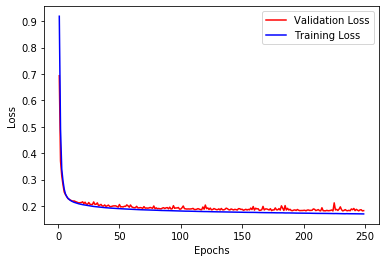

In [ ]:
# Plotting the variation of loss function on both training and validation set: 

import matplotlib.pyplot as plt

val_loss = history_detection.history["val_loss"]
loss = history_detection.history["loss"]

epochs = range(1, 250)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Testing the trained network over the testset.
predictions_label = model_detection.predict(X_tst_detection)
predictions_label_rain = model_detection.predict(Xf_tst_detection)

# Using argmax function to select the label with the highest probability.
y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])
    
y_pred_rain = np.zeros([len(Xf_tst_detection),1])
for i in range(len(Xf_tst_detection)):
    y_pred_rain[i,0] = np.argmax(predictions_label_rain[i])  

### Metrics

In [ ]:
### Detection Module

n_cc=1
n_cs=1
n_cr=1
n_sc=1
n_ss=1
n_sr=1
n_rc=1
n_rs=1
n_rr=1

precip_c= 0
precip_r= 1
precip_s= 2

for i in range(len(X_tst_detection)):
    label_predict = y_pred[i]
    label_actual = t_test[i]
    if label_predict==precip_c and label_actual==precip_c:
        n_cc+=1
    if label_predict==precip_s and label_actual==precip_s:
        n_ss+=1
    if label_predict==precip_r and label_actual==precip_r:
        n_rr+=1 
    if label_predict==precip_c and label_actual==precip_s:
        n_cs+=1
    if label_predict==precip_c and label_actual==precip_r:
        n_cr+=1
    if label_predict==precip_s and label_actual==precip_c:
        n_sc+=1
    if label_predict==precip_s and label_actual==precip_r:
        n_sr+=1  
    if label_predict==precip_r and label_actual==precip_c:
        n_rc+=1
    if label_predict==precip_r and label_actual==precip_s:
        n_rs+=1        
        
#Snow
TP_s = n_ss
TN_s = n_cc+n_cr+n_rc+n_rr
FP_s = n_sc+n_sr
FN_s = n_cs+n_rs

precision_s = TP_s/(TP_s+FP_s)
acc_s = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
recall_s = TP_s/(TP_s+FN_s)
f1_score_s = (2*precision_s*recall_s)/(precision_s+recall_s)
FPR_s = FP_s/(FP_s+TN_s)

#Rain
TP_r = n_rr
TN_r = n_cc+n_cs+n_sc+n_ss
FP_r = n_rc+n_rs
FN_r = n_cr+n_sr

precision_r = TP_r/(TP_r+FP_r)
acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
recall_r = TP_r/(TP_r+FN_r)
f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
FPR_r = FP_r/(FP_r+TN_r) 

print('\n For Rainfall Detection Over Ocean:\n')
print('Precision: ',precision_r)
print('Accuracy: ',acc_r)
print('Recall (TPR): ',recall_r)
print('False Alarm (FPR): ',FPR_r)
print('\nF1 Score: ',f1_score_r)

print('----------------------------')
print('\n For Snwofall Detection Over Ocean:\n')
print('Precision: ',precision_s)
print('Accuracy: ',acc_s)
print('Recall (TPR): ',recall_s)
print('False Alarm (FPR): ',FPR_s)
print('\nF1 Score: ',f1_score_s)

#Model
TP = n_cc+n_ss+n_rr
FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)

print('----------------------------')
print('\n For Model Detection Over Ocean:\n')
print('Precision: ',precision)
print('Recall (TPR): ',recall)
print('\nF1 Score: ',f1_score)


 For Rainfall Detection Over Ocean:

Precision:  0.9120445162448394
Accuracy:  0.9575721770494862
Recall (TPR):  0.9237062174281905
False Alarm (FPR):  0.030740918881616095

F1 Score:  0.9178383260575042
----------------------------

 For Snwofall Detection Over Ocean:

Precision:  0.9232435597189695
Accuracy:  0.9706161284805895
Recall (TPR):  0.9645828235869831
False Alarm (FPR):  0.027327871927959477

F1 Score:  0.9434605719755892
----------------------------

 For Model Detection Over Ocean:

Precision:  0.9282349465959795
Recall (TPR):  0.9282349465959795

F1 Score:  0.9282349465959795


In [ ]:
model_detection.evaluate(X_tst_detection, t_tst_detection, batch_size = batch_size1)

129/129 [==============================] - 0s 1ms/step - loss: 0.1812 - recall: 0.9283


[0.1811523139476776, 0.928318202495575]

## **2.2 - Estimation networks (e-DNN)**

In [ ]:
from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))        

### **2.2.1 Rainfall retrieval**

In [ ]:
# Parameters
hidden_units = 60
dropout = 0

# OCEAN
model_retrieval = Sequential()

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(1))
model_retrieval.add(Activation('relu'))

In [ ]:
model_retrieval.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Rain):\n')
batch_size2 = 100
history_retrieval = model_retrieval.fit(Xf_trn_retrieval, yf_trn_retrieval, epochs=400,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Rain):

Epoch 1/400
207/207 [==============================] - 2s 3ms/step - loss: 5.7577 - mean_absolute_error: 2.2847 - val_loss: 5.9465 - val_mean_absolute_error: 2.3584
Epoch 2/400
207/207 [==============================] - 0s 2ms/step - loss: 5.6282 - mean_absolute_error: 2.2510 - val_loss: 5.8618 - val_mean_absolute_error: 2.3299
Epoch 3/400
207/207 [==============================] - 0s 2ms/step - loss: 5.6007 - mean_absolute_error: 2.2329 - val_loss: 5.7664 - val_mean_absolute_error: 2.3064
Epoch 4/400
207/207 [==============================] - 0s 2ms/step - loss: 5.4788 - mean_absolute_error: 2.2246 - val_loss: 5.6630 - val_mean_absolute_error: 2.2929
Epoch 5/400
207/207 [==============================] - 0s 2ms/step - loss: 5.3717 - mean_absolute_error: 2.2263 - val_loss: 5.5595 - val_mean_absolute_error: 2.2947
Epoch 6/400
207/207 [==============================] - 0s 2ms/step - loss: 5.3439 - mean_absolute_error: 2.2495 - val_loss: 5.4648 - v

207/207 [==============================] - 0s 2ms/step - loss: 4.2205 - mean_absolute_error: 1.8532 - val_loss: 4.2679 - val_mean_absolute_error: 1.8883
Epoch 51/400
207/207 [==============================] - 0s 2ms/step - loss: 4.2232 - mean_absolute_error: 1.8508 - val_loss: 4.2582 - val_mean_absolute_error: 1.8672
Epoch 52/400
207/207 [==============================] - 0s 2ms/step - loss: 4.2208 - mean_absolute_error: 1.8384 - val_loss: 4.2502 - val_mean_absolute_error: 1.8588
Epoch 53/400
207/207 [==============================] - 0s 2ms/step - loss: 4.2382 - mean_absolute_error: 1.8405 - val_loss: 4.2374 - val_mean_absolute_error: 1.8733
Epoch 54/400
207/207 [==============================] - 0s 2ms/step - loss: 4.1765 - mean_absolute_error: 1.8273 - val_loss: 4.2311 - val_mean_absolute_error: 1.8522
Epoch 55/400
207/207 [==============================] - 0s 2ms/step - loss: 4.2258 - mean_absolute_error: 1.8238 - val_loss: 4.2224 - val_mean_absolute_error: 1.8566
Epoch 56/400
207/

207/207 [==============================] - 0s 2ms/step - loss: 4.0731 - mean_absolute_error: 1.6773 - val_loss: 4.0243 - val_mean_absolute_error: 1.6922
Epoch 100/400
207/207 [==============================] - 0s 2ms/step - loss: 4.0326 - mean_absolute_error: 1.6750 - val_loss: 4.0237 - val_mean_absolute_error: 1.6879
Epoch 101/400
207/207 [==============================] - 0s 2ms/step - loss: 4.0315 - mean_absolute_error: 1.6753 - val_loss: 4.0216 - val_mean_absolute_error: 1.6933
Epoch 102/400
207/207 [==============================] - 0s 2ms/step - loss: 4.0523 - mean_absolute_error: 1.6716 - val_loss: 4.0214 - val_mean_absolute_error: 1.6805
Epoch 103/400
207/207 [==============================] - 0s 2ms/step - loss: 4.0311 - mean_absolute_error: 1.6712 - val_loss: 4.0206 - val_mean_absolute_error: 1.6788
Epoch 104/400
207/207 [==============================] - 0s 2ms/step - loss: 4.0079 - mean_absolute_error: 1.6701 - val_loss: 4.0161 - val_mean_absolute_error: 1.6966
Epoch 105/40

207/207 [==============================] - 0s 2ms/step - loss: 3.9386 - mean_absolute_error: 1.6177 - val_loss: 3.9566 - val_mean_absolute_error: 1.6556
Epoch 149/400
207/207 [==============================] - 1s 2ms/step - loss: 3.9604 - mean_absolute_error: 1.6220 - val_loss: 3.9549 - val_mean_absolute_error: 1.6532
Epoch 150/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9790 - mean_absolute_error: 1.6198 - val_loss: 3.9546 - val_mean_absolute_error: 1.6367
Epoch 151/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9310 - mean_absolute_error: 1.6115 - val_loss: 3.9536 - val_mean_absolute_error: 1.6519
Epoch 152/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9727 - mean_absolute_error: 1.6211 - val_loss: 3.9527 - val_mean_absolute_error: 1.6289
Epoch 153/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9656 - mean_absolute_error: 1.6105 - val_loss: 3.9517 - val_mean_absolute_error: 1.6388
Epoch 154/40

207/207 [==============================] - 0s 2ms/step - loss: 3.9345 - mean_absolute_error: 1.5867 - val_loss: 3.9022 - val_mean_absolute_error: 1.6024
Epoch 198/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9037 - mean_absolute_error: 1.5794 - val_loss: 3.9005 - val_mean_absolute_error: 1.6071
Epoch 199/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9277 - mean_absolute_error: 1.5832 - val_loss: 3.8992 - val_mean_absolute_error: 1.6117
Epoch 200/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8992 - mean_absolute_error: 1.5772 - val_loss: 3.8990 - val_mean_absolute_error: 1.5969
Epoch 201/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9196 - mean_absolute_error: 1.5810 - val_loss: 3.8978 - val_mean_absolute_error: 1.5932
Epoch 202/400
207/207 [==============================] - 0s 2ms/step - loss: 3.9178 - mean_absolute_error: 1.5699 - val_loss: 3.8965 - val_mean_absolute_error: 1.6008
Epoch 203/40

207/207 [==============================] - 0s 2ms/step - loss: 3.8397 - mean_absolute_error: 1.5464 - val_loss: 3.8637 - val_mean_absolute_error: 1.5641
Epoch 247/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8622 - mean_absolute_error: 1.5521 - val_loss: 3.8613 - val_mean_absolute_error: 1.5678
Epoch 248/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8720 - mean_absolute_error: 1.5517 - val_loss: 3.8609 - val_mean_absolute_error: 1.5882
Epoch 249/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8732 - mean_absolute_error: 1.5548 - val_loss: 3.8586 - val_mean_absolute_error: 1.5843
Epoch 250/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8923 - mean_absolute_error: 1.5526 - val_loss: 3.8568 - val_mean_absolute_error: 1.5880
Epoch 251/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8582 - mean_absolute_error: 1.5592 - val_loss: 3.8569 - val_mean_absolute_error: 1.5677
Epoch 252/40

207/207 [==============================] - 0s 2ms/step - loss: 3.8036 - mean_absolute_error: 1.5325 - val_loss: 3.8273 - val_mean_absolute_error: 1.5543
Epoch 296/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8315 - mean_absolute_error: 1.5311 - val_loss: 3.8254 - val_mean_absolute_error: 1.5692
Epoch 297/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8127 - mean_absolute_error: 1.5282 - val_loss: 3.8249 - val_mean_absolute_error: 1.5802
Epoch 298/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8319 - mean_absolute_error: 1.5367 - val_loss: 3.8238 - val_mean_absolute_error: 1.5616
Epoch 299/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8287 - mean_absolute_error: 1.5341 - val_loss: 3.8222 - val_mean_absolute_error: 1.5559
Epoch 300/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8182 - mean_absolute_error: 1.5280 - val_loss: 3.8232 - val_mean_absolute_error: 1.5812
Epoch 301/40

207/207 [==============================] - 0s 2ms/step - loss: 3.8009 - mean_absolute_error: 1.5172 - val_loss: 3.8072 - val_mean_absolute_error: 1.5304
Epoch 345/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7718 - mean_absolute_error: 1.5093 - val_loss: 3.8058 - val_mean_absolute_error: 1.5506
Epoch 346/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7895 - mean_absolute_error: 1.5148 - val_loss: 3.8060 - val_mean_absolute_error: 1.5310
Epoch 347/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7591 - mean_absolute_error: 1.5109 - val_loss: 3.8046 - val_mean_absolute_error: 1.5393
Epoch 348/400
207/207 [==============================] - 0s 2ms/step - loss: 3.8149 - mean_absolute_error: 1.5153 - val_loss: 3.8038 - val_mean_absolute_error: 1.5472
Epoch 349/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7769 - mean_absolute_error: 1.5120 - val_loss: 3.8032 - val_mean_absolute_error: 1.5564
Epoch 350/40

207/207 [==============================] - 0s 2ms/step - loss: 3.7317 - mean_absolute_error: 1.5000 - val_loss: 3.7922 - val_mean_absolute_error: 1.5567
Epoch 394/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7590 - mean_absolute_error: 1.5031 - val_loss: 3.7917 - val_mean_absolute_error: 1.5394
Epoch 395/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7595 - mean_absolute_error: 1.5025 - val_loss: 3.7925 - val_mean_absolute_error: 1.5364
Epoch 396/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7472 - mean_absolute_error: 1.5028 - val_loss: 3.7915 - val_mean_absolute_error: 1.5431
Epoch 397/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7907 - mean_absolute_error: 1.5016 - val_loss: 3.7901 - val_mean_absolute_error: 1.5384
Epoch 398/400
207/207 [==============================] - 0s 2ms/step - loss: 3.7443 - mean_absolute_error: 1.5015 - val_loss: 3.7897 - val_mean_absolute_error: 1.5385
Epoch 399/40

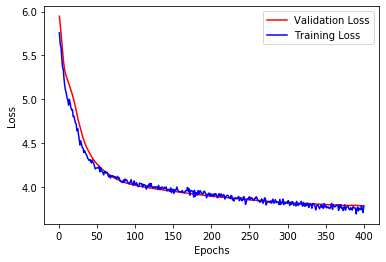

In [ ]:
val_loss = history_retrieval.history["val_loss"]
loss = history_retrieval.history["loss"]

epochs = range(1, 401)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_rain = model_retrieval.predict(Xf_tst_retrieval)

In [ ]:
model_retrieval.evaluate(Xf_tst_retrieval, yf_tst_retrieval, batch_size = batch_size2)

113/113 [==============================] - 0s 1ms/step - loss: 4.6299 - mean_absolute_error: 1.8330


[4.629871368408203, 1.832980751991272]

# **3. Saving the models**

In [ ]:
import scipy
from scipy.io import savemat

model_retrieval.save('Models\CPR\Ocean\model_rain',save_format='h5')
fp_CPR_ocean_RR = 'Models/CPR/Ocean/files_CPR_ocean_RR.mat'
scipy.io.savemat(fp_CPR_ocean_RR, {'mean_rain_retrieval_CPR_ocean_RR': mean_retrieval,'std_rain_retrieval_CPR_ocean_RR':std_retrieval})